# Part 3: Asset data dive
Let's get started with a guided exploration of the Valhall Platform. In this notebook we will pick one of the equipment that we visualized in operational intelligence and take a closer look at all of the available data!


## Quick links
* Back to the [Hackathon github repo](https://github.com/cognitedata/open-industrial-data/tree/master/workshops/uni-hackathon)
* Documentation of [CDP concepts](https://doc.cognitedata.com/concepts/)
* Reference documentation for the [Python SDK](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/))
<hr>

# Step 0: Environment Setup

#### Install the Cognite SDK package

In [1]:
# if you're working in google colab or similar
!pip install -q cognite-sdk

#### Import the required packages

In [2]:
%matplotlib inline

import os
from datetime import datetime, timedelta
from datetime import datetime
from getpass import getpass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from cognite import CogniteClient

pd.set_option('display.max_rows', 10)

#### Connect to the Cognite Data Platform
The SDK client is the entrypoint to all data in CDP, and simply requires the API key that you generated in Part 1.

When prompted for your API key, use the key generated by open industrial data as mentioned in the Getting Started steps.

In [3]:
client = CogniteClient(api_key=getpass("Open Industrial Data API-KEY: "))

Open Industrial Data API-KEY: ········


# Step 1: Learn about Organizing Industrial Data

The Cognite Data Platform organizes digital information about the physical world. The building blocks of this representation are called *resources*, which you can read up on in detail [here](https://doc.cognitedata.com/concepts/#core-concepts).

An important resource to understand is the Asset resource. This is the foundation for organizing industrial data -- time series, work orders, event logs and arbitrary files -- from across complex industrial systems.
Assets are linked together with parent-child relationships to build a top-down hierarchical tree, known as "The Asset Hierarchy".
For example, an Asset Hierarchy could look like this:
```
  Gas Export Compressor
    |- First stage export compressor
    |    |- Compressor
    |    |- Scrubber
    |    |- ...
    |- Second stage export compressor
    |- ...
```
Timeseries, events, files and other resources are attached to each Asset.

The hierarchical structure can make it easier to find the timeseries data that you're looking for. Though there are [other ways](https://doc.cognitedata.com/concepts/#_3d-models-and-revisions) to do this, we'll focus on using the hierarchy today!

In [4]:
# download a sample of assets up to a certain depth in the hierarchy
df_sample_assets = client.assets.get_assets(limit=1000, depth=4).to_pandas().sort_values('depth')
df_sample_assets

,createdTime,depth,description,id,lastUpdatedTime,metadata,name,parentId,path
5,0,0,Aker BP,6687602007296940,0,NaN,Aker BP,NaN,[6687602007296940]
6,1534854951557,0,Valhall plattform,2675073401706610,1534854951557,"{'SOURCE_DB': 'workmate', 'SOURCE_TABLE': 'wma...",VAL,NaN,[2675073401706610]
7,0,1,Valhall plattform,4650652196144007,1549825208650,"{'SOURCE_DB': 'workmate', 'SOURCE_TABLE': 'wma...",VAL,6.687602e+15,"[6687602007296940, 4650652196144007]"
0,0,2,GAS COMPRESSION AND RE-INJECTION (PH),3111454725058294,0,"{'SOURCE_DB': 'workmate', 'SOURCE_TABLE': 'wma...",23,4.650652e+15,"[6687602007296940, 4650652196144007, 311145472..."
4,0,3,GAS COMPRESSION AND RE-INJECTION ON PH,6895991969886325,0,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",230900,3.111455e+15,"[6687602007296940, 4650652196144007, 311145472..."
1,0,4,1ST STAGE COMPRESSION ON PH,4518112062673878,0,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",23-1ST STAGE COMPRESSION-PH,6.895992e+15,"[6687602007296940, 4650652196144007, 311145472..."
2,0,4,2ND STAGE COMPRESSION ON PH,5786472304680477,0,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",23-2ND STAGE COMPRESSION-PH,6.895992e+15,"[6687602007296940, 4650652196144007, 311145472..."
3,0,4,VRD - PH 1STSTGDISCCOOL COOLMED IN,1150715783816357,0,"{'ELC_STATUS_ID': '1212', 'SOURCE_DB': 'workma...",23-TT-92604B,6.895992e+15,"[6687602007296940, 4650652196144007, 311145472..."


# Step 2: Pick an asset for further investigation
For the rest of the workshop, you'll be working with one of the subsystems that you visualized in the [LIVE Operational Intelligence System Overview](https://opint.cogniteapp.com/publicdata/infographics/-LOHKEJPLvt0eRIZu8mE) (see below).
Either pick an asset yourself below, or let fate decide ;)


In [5]:
import random
SYSTEM_OVERVIEW_ASSETS = [
    '23-ESDV-92501A',
    '23-ESDV-92501B',
    '23-HA-9103',
    '23-PV-92538',
    '23-VG-9101',
    '23-KA-9101',
    '23-HA-9115',
    '23-HA-9114',
    '23-FV-92543',
    '23-ESDV-92551A',
    '23-ESDV-92551B',
]

In [6]:
# fetch the asset metadata from CDP using the assets client

df_system_overview_assets = pd.concat([
    client.assets.get_assets(name=n).to_pandas()
    for n in SYSTEM_OVERVIEW_ASSETS
])[['name', 'id', 'parentId', 'description']].set_index('name')

df_system_overview_assets

,id,parentId,description
name,,,
23-ESDV-92501A,576308321452985,2861239574637735,VRD - PH 1STSTGSUCTCLR GAS IN
23-ESDV-92501B,1659945743622682,2861239574637735,VRD - PH 1STSTGSUCTCLR GAS IN EQUAL
23-HA-9103,2861239574637735,2513266419866445,VRD - 1ST STAGE SUCTION COOLER
23-PV-92538,3956345651792907,2861239574637735,VRD - PH 1STSTGCOMP SUCTION STV
23-VG-9101,53231887945301,4518112062673878,VRD - 1ST STAGE SUCTION SCRUBBER
...,...,...,...
23-HA-9115,1305599545806638,2513266419866445,VRD - 1ST STAGE DISCHARGE COOLER 2
23-HA-9114,5345363121325760,2513266419866445,VRD - 1ST STAGE DISCHARGE COOLER 1
23-FV-92543,6045313781173559,5345363121325760,VRD - PH 1STSTGCOMP ANTI-SURGE


In [13]:
# Choose an asset for analysis, or let fate decide :)

asset_name = '23-HA-9103' #random.choice(SYSTEM_OVERVIEW_ASSETS)

asset_id = df_system_overview_assets.loc[asset_name, 'id']

print("And my asset is!")
df_system_overview_assets.loc[asset_name]

And my asset is!


id                           2861239574637735
parentId                     2513266419866445
description    VRD - 1ST STAGE SUCTION COOLER
Name: 23-HA-9103, dtype: object

# Step 3: Find all the timeseries for your asset

The interface `client.assets.get_asset_subtree()` can be used to retrieve all of the *children* of an Asset. The `depth` parameter sets how far we traverse down the hierarchy.

In [14]:
df_asset_children = client.assets.get_asset_subtree(
    asset_id=df_system_overview_assets.loc[asset_name, 'id'],
    depth=10
).to_pandas().sort_values('depth')
df_asset_children[['depth', 'id', 'parentId', 'description']]

,depth,id,parentId,description
0,6,2861239574637735,2513266419866445,VRD - 1ST STAGE SUCTION COOLER
24,7,8624522362488710,2861239574637735,VRD - PH 1STSTGSUCTCOOL GAS IN
23,7,786220428505816,2861239574637735,VRD - PH 1STSTGSUCTCOOL GAS IN
22,7,7835659687560027,2861239574637735,VRD - PH 1STSTGSUCTCOOL SHELL
20,7,7390359759479147,2861239574637735,VRD - PH 1STSTGSUCTCLR COOLMED SPLY
...,...,...,...,...
54,8,7059124259738257,3956345651792907,SOFT TAG VRD - PH 1STSTGCOMP SUCTION STV
109,9,6446057900446956,6660446659282082,SOFT TAG VRD - PH 1STSTGCOMP SUCTION STV
107,9,3238213380644965,6660446659282082,SOFT TAG VRD - PH 1STSTGCOMP SUCTION STV
108,9,3685495958214989,6660446659282082,VRD - PH 1STSTGCOMP SUCTION STV : POSITION ALA...


... Assets are interesting to see how things are put together, but what I'm sure you're really after are those petabytes of **time series**; those beautiful pressure (PT), temperature (TT) and flow (TT) sensors that have recorded the life of the platform for the last few years.

First we need to find all these time series. We can use the `path` parameter in the `time_series` client to get all the time series attached to assets below our system overview asset. Note that this parameter maps directly to the CDP API, and therefore needs to provide the asset id formatted carefully as a json string: `"[id, ]"`.

In [15]:
df_asset_children_timeseries = client.time_series.get_time_series(path=str([asset_id])).to_pandas()
df_asset_children_timeseries

,assetId,createdTime,description,id,isStep,isString,lastUpdatedTime,name
0,2853212781345885,0,PH,8262972156481883,False,False,0,VAL_23-ESDV-92501A-PST:VALUE
1,697868726228674,0,PH,5031402569252903,False,False,0,VAL_23-ESDV-92501B-PST:VALUE
2,406413349837069,0,PH 1stStgSuctCool Gas In (Norm),3254379523070838,False,False,0,VAL_23-FI-92512A:X.Value
3,1636124668055370,0,PH 1stStgSuctCool Gas In (Std),2254180903225245,False,False,0,VAL_23-FI-92512B:X.Value
4,786220428505816,0,PH 1stStgSuctCool Gas In,3518012501014915,False,False,0,VAL_23-FT-92512:X.Value
...,...,...,...,...,...,...,...,...
32,5497674254221099,0,PH 1stStgSuctCool CoolMed In,1920137775628302,False,False,0,VAL_45-FT-92506:X.Value
33,7835659687560027,0,PH 1stStgSuctCool Shell,1804879717768950,False,False,0,VAL_45-PDT-92506:X.Value
34,705952550422793,0,PH 1stStgSuctCool CoolMed Out,3529821833330815,False,False,0,VAL_45-PT-92508:X.Value
35,7390359759479147,0,PH 1stStgSuctClr CoolMed Sply,2288456938237513,False,False,0,VAL_45-TT-92506:X.Value


Great! We have discovered the timeseries below our asset!

**Note**: CDP can also store string and step timeseries. Step timeseries have different aggregation methods, and support dead-band-compression for time series that do not change very often (e.g. valve opening angles).

# Step 4: Into the timeseries datapoints!
In CDP we do some very clever things in the backend to store serve up timeseries just the way you like it:
- Store the timeseries (timestamp, value) in their raw format, because one day we'll need it
- Precompute aggregations for millisecond response times
- Build tabular structures server side
- Enable natural language time specifications (e.g. `start='8d-ago'` and `granularity='10m'`)

So once you've located the timeseries you're interested in analyzing, the `datapoints` client has several options for downloading the data.

**Note:** The timeseries column is represented throughout CDP as milliseconds since epoch time. Pandas offers an easy conversion to python datetime with `pd.to_datetime(<column/value>, unit='ms')`.

In [16]:
# set aside string time series for now because they do not aggregate together with numerical time series
# consider investigating the string timeseries in part 4b
lst_timeseries = df_asset_children_timeseries[~df_asset_children_timeseries['isString']]['name'].tolist()
lst_timeseries

['VAL_23-ESDV-92501A-PST:VALUE',
 'VAL_23-ESDV-92501B-PST:VALUE',
 'VAL_23-FI-92512A:X.Value',
 'VAL_23-FI-92512B:X.Value',
 'VAL_23-FT-92512:X.Value',
 'VAL_23-PDT-92501:X.Value',
 'VAL_23-PDT-92502:X.Value',
 'VAL_23-PT-92504:X.Value',
 'VAL_23-PT-92512:X.Value',
 'VAL_23-TIC-92504:Control Module:BA',
 'VAL_23-TIC-92504:Control Module:BX',
 'VAL_23-TIC-92504:Control Module:PD',
 'VAL_23-TIC-92504:Control Module:PI',
 'VAL_23-TIC-92504:Control Module:PP',
 'VAL_23-TIC-92504:Control Module:YR',
 'VAL_23-TIC-92504:Z.X.Value',
 'VAL_23-TIC-92504:Z.Y.Value',
 'VAL_23-TT-92502:X.Value',
 'VAL_23-TT-92512:X.Value',
 'VAL_23_PIC_92538_01:Z.X.Value',
 'VAL_23_PIC_92538_02:Z.X.Value',
 'VAL_23_PIC_92538_03:Z.X.Value',
 'VAL_23_PIC_92538_04:Z.X.Value',
 'VAL_23_PIC_92538_05:Z.X.Value',
 'VAL_23_PIC_92538_06:Z.X.Value',
 'VAL_23_PIC_92538_07:Z.X.Value',
 'VAL_23_PIC_92538_08:Z.X.Value',
 'VAL_23_PIC_92538_09:Z.X.Value',
 'VAL_23_PIC_92538_12:Z.X.Value',
 'VAL_23_PIC_92538_13:Z.X.Value',
 'VAL_23

In [17]:
df_data = client.datapoints.get_datapoints_frame(
    time_series=lst_timeseries,
    aggregates=['avg'],
    granularity='1h',
    start='30d-ago',
)

df_data = df_data.set_index(pd.to_datetime(df_data['timestamp'], unit='ms')).drop('timestamp', axis=1)
df_data

,VAL_23-ESDV-92501A-PST:VALUE|average,VAL_23-ESDV-92501B-PST:VALUE|average,VAL_23-FI-92512A:X.Value|average,VAL_23-FI-92512B:X.Value|average,VAL_23-FT-92512:X.Value|average,VAL_23-PDT-92501:X.Value|average,VAL_23-PDT-92502:X.Value|average,VAL_23-PT-92504:X.Value|average,VAL_23-PT-92512:X.Value|average,VAL_23-TIC-92504:Control Module:BA|average,...,VAL_23_PIC_92538_08:Z.X.Value|average,VAL_23_PIC_92538_09:Z.X.Value|average,VAL_23_PIC_92538_12:Z.X.Value|average,VAL_23_PIC_92538_13:Z.X.Value|average,VAL_23_ZT_92538:Z.X.Value|average,VAL_45-FT-92506:X.Value|average,VAL_45-PDT-92506:X.Value|average,VAL_45-PT-92508:X.Value|average,VAL_45-TT-92506:X.Value|average,VAL_45-TT-92508:X.Value|average
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-11 19:00:00,0.0,0.0,NaN,NaN,104912.766975,0.001350,0.274272,3.257778,3.387471,1.0,...,12.726582,13.898413,2.707961,2.09768,85.457536,0.0,0.203370,2.184859,7.892084,10.507245
2019-01-11 20:00:00,0.0,0.0,NaN,NaN,104689.440115,0.001391,0.272258,3.263860,3.393377,1.0,...,12.732507,13.898413,2.710251,2.09768,85.396587,0.0,0.204389,2.164329,7.822938,10.698466
2019-01-11 21:00:00,0.0,0.0,NaN,NaN,105503.305111,0.001278,0.274601,3.256339,3.386649,1.0,...,12.733041,13.898413,2.712327,2.09768,85.738949,0.0,0.203839,2.179239,7.802811,10.985418
2019-01-11 22:00:00,0.0,0.0,NaN,NaN,103828.539683,0.001401,0.271065,3.261109,3.390861,1.0,...,12.710917,13.898413,2.709439,2.09768,85.524755,0.0,0.203405,2.201123,7.782083,11.286964
2019-01-11 23:00:00,0.0,0.0,NaN,NaN,105594.286035,0.001272,0.273845,3.260163,3.390062,1.0,...,12.739081,13.898413,2.724799,2.09768,85.848583,0.0,0.204117,2.182555,7.768010,11.554581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-03 15:00:00,0.0,0.0,NaN,NaN,87261.116737,0.000258,0.250271,3.265729,3.389775,NaN,...,12.709225,NaN,2.698785,NaN,85.291225,0.0,0.232071,2.164343,10.945626,32.534640
2019-02-03 16:00:00,0.0,0.0,NaN,NaN,86920.383758,-0.000112,0.248589,3.263101,3.387191,NaN,...,12.725036,NaN,2.703396,NaN,85.466940,0.0,0.224837,2.202623,9.325626,26.151368
2019-02-03 17:00:00,0.0,0.0,NaN,NaN,87993.790888,0.000526,0.253128,3.266748,3.391310,NaN,...,12.708518,NaN,2.700230,NaN,85.116041,0.0,0.224807,2.194910,8.160001,20.871790


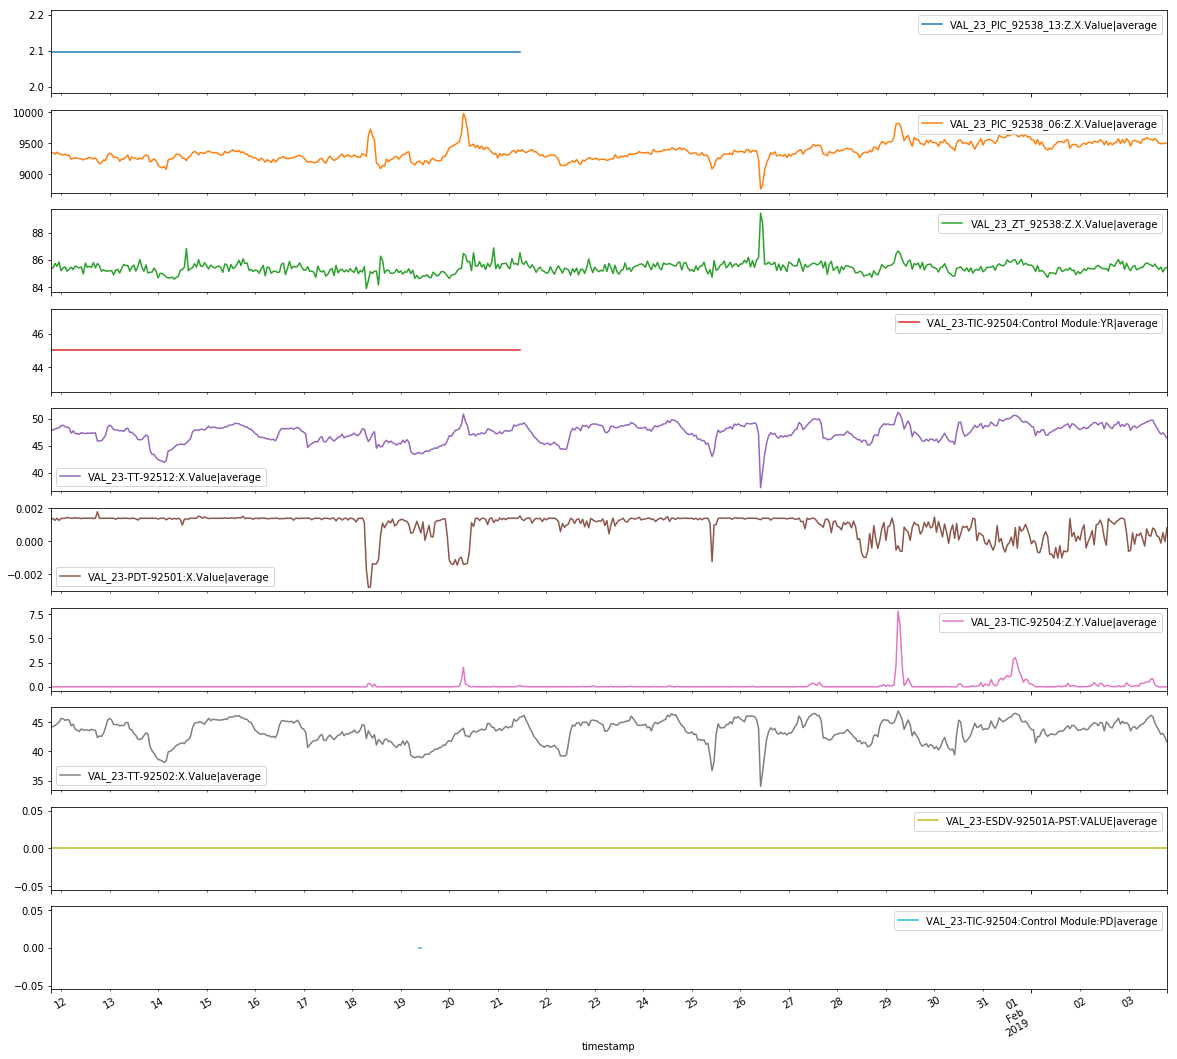

In [18]:
# plot up to 10 random rows
df_plot_sample = df_data[random.sample(list(df_data.columns), min(10, len(df_data.columns)))]

df_plot_sample.plot(subplots=True, figsize=(20,20));

# Congratulations, you are done with part 3!

Save your notebook, and remember your asset for the next part, where we dig deeper into the data.